# LRC Circuit

In [1]:
import jax
import jax.numpy as jnp
import diffrax

from circulus.components import Resistor, Capacitor, Inductor, VoltageSource
from circulus.compiler import compile_netlist
from circulus.solvers.transient import VectorizedTransientSolver
from circulus.solvers.strategies import DenseSolver

import matplotlib.pyplot as plt

KLUJAX_RS DEBUG MODE.


In this example, we simulate a classical Series RLC Circuit operating in the gigahertz (RF) regime. The circuit consists of a voltage source, a resistor ($10\Omega$), an inductor ($5\text{nH}$), and a capacitor ($10\text{pF}$) connected in series. As the resistance ($R=10\Omega$) is lower than the characteristic impedance of the LC tank ($2\sqrt{L/C} \approx 44.7\Omega$), this system is underdamped. When the voltage source activates, energy will oscillate between the inductor's magnetic field and the capacitor's electric field, creating a "ringing" effect that decays over time.

In [6]:
net_dict = {
    "instances": {
        "GND": {"component":"ground"},
        "V1": {"component":"source_voltage", "settings":{"V": 1.0,"delay":0.25E-9}},
        "R1": {"component":"resistor", "settings":{"R": 10.0}},
        "C1": {"component":"capacitor", "settings":{"C": 1e-11}},
        "L1": {"component":"inductor", "settings":{"L": 5e-9}},
    },
    "connections": {
        "GND,p1": ("V1,p2", "C1,p2"),
        "V1,p1": "R1,p1",
        "R1,p2": "L1,p1",
        "L1,p2": "C1,p1",
    },
}

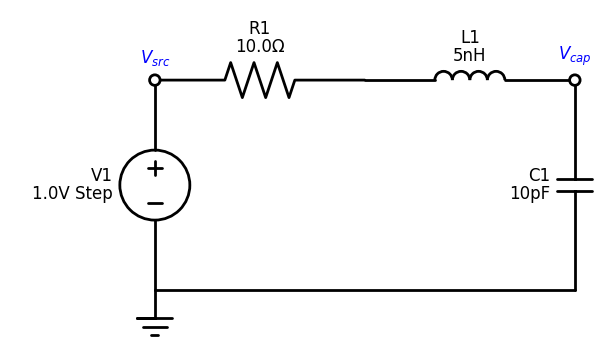

In [7]:
import schemdraw
import schemdraw.elements as elm

# --- Helper for nice engineering labels ---
def get_formatted_label(instance_id):
    inst = net_dict["instances"][instance_id]
    comp_type = inst["component"]
    s = inst.get("settings", {})
    
    label = f"{instance_id}"
    
    if comp_type == "resistor":
        label += f"\n{s['R']}Ω"
    elif comp_type == "inductor":
        # Format scientific notation to prefixes (nH)
        val = s['L']
        if val < 1e-6: label += f"\n{val*1e9:.0f}nH"
        elif val < 1e-3: label += f"\n{val*1e6:.0f}µH"
        else: label += f"\n{val}H"
    elif comp_type == "capacitor":
        # Format prefixes (pF, nF)
        val = s['C']
        if val < 1e-9: label += f"\n{val*1e12:.0f}pF"
        elif val < 1e-6: label += f"\n{val*1e9:.0f}nF"
        else: label += f"\n{val}F"
    elif comp_type == "source_voltage":
        label += f"\n{s['V']}V Step"
        
    return label

# --- Drawing Routine ---
with schemdraw.Drawing() as d:
    d.config(fontsize=12, unit=3, inches_per_unit=0.7) # Adjust unit size for better proportions

    # 1. Voltage Source (V1) starting from Ground
    # Using SourceV (battery style) to represent the DC step potential
    V1 = d.add(elm.SourceV()
               .up()
               .label(get_formatted_label("V1")))

    # 2. Resistor (R1) in series along the top rail
    R1 = d.add(elm.Resistor()
               .right()
               .at(V1.end) # Connect to top of V1
               .label(get_formatted_label("R1")))

    # 3. Inductor (L1) in series
    L1 = d.add(elm.Inductor()
               .right()
               .at(R1.end)
               .label(get_formatted_label("L1")))

    # 4. Capacitor (C1) completing the loop down to ground rail
    C1 = d.add(elm.Capacitor()
               .down()
               .at(L1.end)
               .label(get_formatted_label("C1")))

    # 5. Return path to Ground
    # Connect bottom of C1 back to bottom of V1
    d.add(elm.Line().to(V1.start))
    
    # Add the Ground symbol at the common rail
    d.add(elm.Ground().at(V1.start))

    # (Optional) Add nodes to show where you might probe voltage
    d.add(elm.Dot(open=True).at(V1.end).label('$V_{src}$', loc='top', color='blue'))
    d.add(elm.Dot(open=True).at(L1.end).label('$V_{cap}$', loc='top', color='blue'))

Compiling...
{'C1,p1': 1, 'L1,p2': 1, 'C1,p2': 0, 'GND,p1': 0, 'V1,p2': 0, 'L1,p1': 2, 'R1,p2': 2, 'V1,p1': 3, 'R1,p1': 3}
Total System Size: 6
Group: source_voltage
  Count: 1
  Var Indices Shape: (1, 3)
  Sample Var Indices:[[3 0 4]]
  Jacobian Rows Length: 1
Group: resistor
  Count: 1
  Var Indices Shape: (1, 2)
  Sample Var Indices:[[3 2]]
  Jacobian Rows Length: 1
Group: capacitor
  Count: 1
  Var Indices Shape: (1, 2)
  Sample Var Indices:[[1 0]]
  Jacobian Rows Length: 1
Group: inductor
  Count: 1
  Var Indices Shape: (1, 3)
  Sample Var Indices:[[2 1 5]]
  Jacobian Rows Length: 1
2. Solving DC Operating Point...
3. Running Simulation...


100.00%|██████████| [00:00<00:00, 4617.19%/s]

4. Plotting...


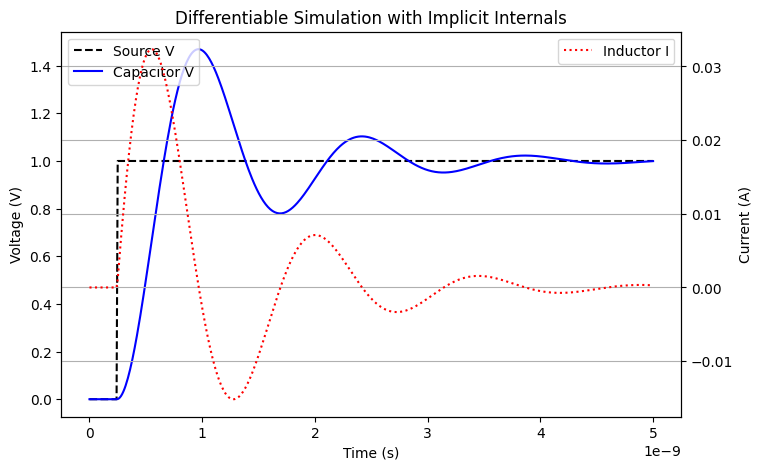

In [ ]:
jax.config.update("jax_enable_x64", True)


models_map = {
    'resistor': Resistor,
    'capacitor': Capacitor,
    'inductor': Inductor,
    'source_voltage': VoltageSource,
    'ground': lambda: 0
}

print("Compiling...")
groups, sys_size, port_map = compile_netlist(net_dict, models_map)

print(port_map)

print(f"Total System Size: {sys_size}")
for g_name, g in groups.items():
    print(f"Group: {g_name}")
    print(f"  Count: {g.var_indices.shape[0]}")
    print(f"  Var Indices Shape: {g.var_indices.shape}")
    print(f"  Sample Var Indices:{g.var_indices}")
    print(f"  Jacobian Rows Length: {len(g.jac_rows)}")

print("2. Solving DC Operating Point...")
linear_strat = DenseSolver.from_circuit(groups, sys_size, is_complex=False)

y_guess = jnp.zeros(sys_size)
y_op = linear_strat.solve_dc(groups,y_guess)

solver = VectorizedTransientSolver(linear_solver=linear_strat)
term = diffrax.ODETerm(lambda t, y, args: jnp.zeros_like(y))


t_max = 5E-9
saveat = diffrax.SaveAt(ts=jnp.linspace(0, t_max, 500))
print("3. Running Simulation...")
sol = diffrax.diffeqsolve(
    term, solver, t0=0.0, t1=t_max, dt0=1e-3*t_max, 
    y0=y_op, args=(groups, sys_size),
    saveat=saveat, max_steps=100000,
    progress_meter=diffrax.TqdmProgressMeter(refresh_steps=100)
)

ts = sol.ts
v_src = sol.ys[:, port_map["V1,p1"]]
v_cap = sol.ys[:, port_map["C1,p1"]]
i_ind = sol.ys[:, 5]

print("4. Plotting...")
fig, ax1 = plt.subplots(figsize=(8, 5))
ax1.plot(ts, v_src, 'k--', label='Source V')
ax1.plot(ts, v_cap, 'b-', label='Capacitor V')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Voltage (V)')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(ts, i_ind, 'r:', label='Inductor I')
ax2.set_ylabel('Current (A)')
ax2.legend(loc='upper right')

plt.title("Differentiable Simulation with Implicit Internals")
plt.grid(True)
plt.show()